# Unit 2
Unit 2 is divided into two parts -- 1st part consist of Finetuning and guiding while the 2nd part is Class conditioned Diffusion model Index.

## Part 2 - Fine-Tuning and Guidance

Fine-Tuning is re-training the existing model on new data to change the type of output they produce.
Guidance is controlling the output by steering the generation process at inference time for existing model.

Now the first is to first login to the huggingface_hub with access token.

In [1]:
from huggingface_hub import notebook_login

notebook_login()

### Importing the important packages

In [2]:
# numpy is for creating matrices or array
import numpy as np
# torch is the framework used for representing data and creating models
import torch
import torch.nn.functional as f
import torchvision
# dataset packages is used for loading data
from datasets import load_dataset
# DDIMScheduler and DDPMPipeline are packages used for scheduling noise and creating pipeline respectively.
from diffusers import DDIMScheduler, DDPMPipeline
# matplotlib is useful for repressing graphs and images
import matplotlib.pyplot as plt
# Pillow or PIL is for printing images
from PIL import Image
# transforms is for data augmentation
from torchvision import transforms
# tqdm is for showing progress bars
from tqdm.auto import tqdm

device = ("cuda" if torch.cuda.is_available() else "cpu")

### Loading a Pre-Trained Pipeline

Now I will load a pre trained pipleine of celebahq by google. Later on this pipeline will be used for fine-tuning.

In [17]:
image_pipe=DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
image_pipe.to(device)

diffusion_pytorch_model.safetensors not found


DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.18.2",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

  0%|          | 0/1000 [00:00<?, ?it/s]

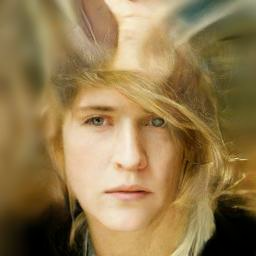

In [5]:
images = image_pipe().images
images[0]

DDPMScheduler is quite good but considered slow in inference. It is found that using 1000 steps for inferencing is unnecessary. To decrease the Sampling time, DDIMScheduler or Denoising Diffusion Implicit Models is introduced.
In DDPM, model is fed a noisy input at every step and asked to predic the noise. But in case for DDIM, we skip some steps thus covering more steps at a time.

In [10]:
scheduler = DDIMScheduler.from_pretrained("google/ddpm-celebahq-256")
scheduler.set_timesteps(num_inference_steps=40)

In [7]:
scheduler.timesteps

tensor([975, 950, 925, 900, 875, 850, 825, 800, 775, 750, 725, 700, 675, 650,
        625, 600, 575, 550, 525, 500, 475, 450, 425, 400, 375, 350, 325, 300,
        275, 250, 225, 200, 175, 150, 125, 100,  75,  50,  25,   0])

As we can see, instead of going step by step each time DDIM takes 25 steps at a time thus covering 1000 steps in just 40 steps. 

0it [00:00, ?it/s]

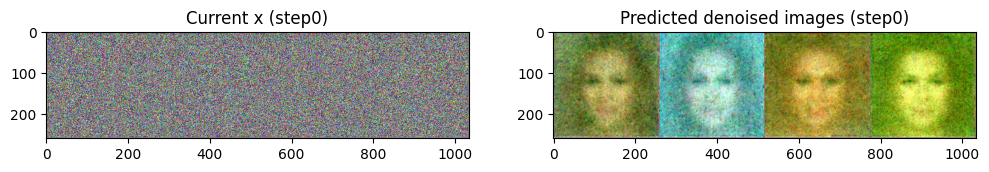

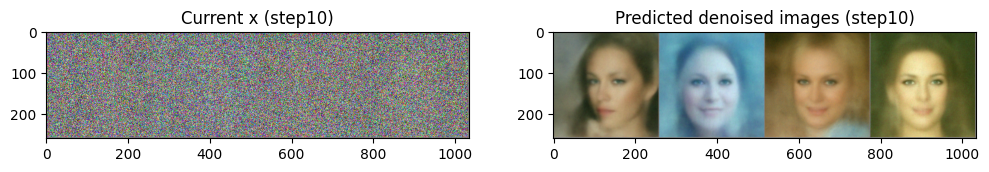

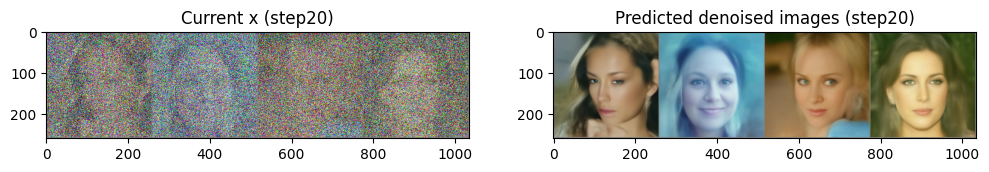

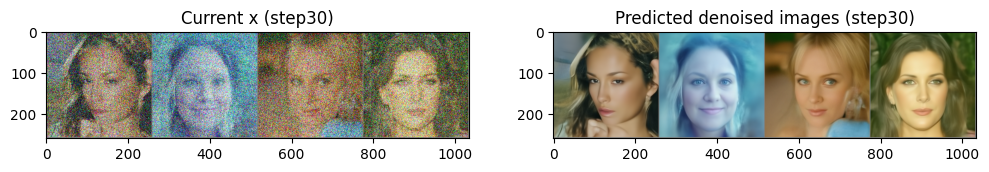

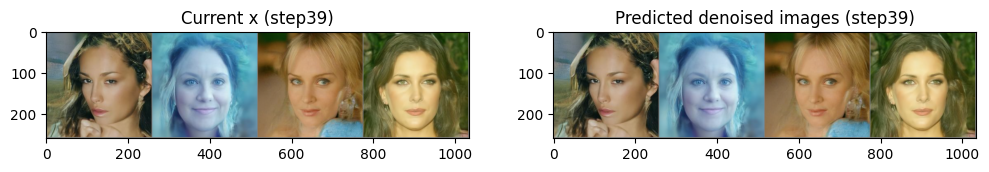

In [10]:
# The random starting point
x = torch.randn(4, 3, 256, 256).to(device) # Batch of 4, 3 channel and 256 x 256 pixels

# Looping through the sampling timesteps
for i, t in tqdm(enumerate(scheduler.timesteps)):

    # Preparing model input
    model_input = scheduler.scale_model_input(x, t)

    # Getting the Prediction
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    # Calculating the output with scheduler
    scheduler_output = scheduler.step(noise_pred, t, x)

    # Updating X
    x = scheduler_output.prev_sample

    # Printing both x and predicted denoised images
    if i % 10 == 0 or i == len(scheduler.timesteps) - 1:
        fig, axis = plt.subplots(1, 2, figsize=(12, 15))

        grid = torchvision.utils.make_grid(x, nrow=4).permute(1, 2, 0)
        axis[0].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
        axis[0].set_title(f"Current x (step{i})")

        pred_x0 = (scheduler_output.pred_original_sample)
        grid = torchvision.utils.make_grid(pred_x0, nrow=4).permute(1, 2, 0)
        axis[1].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
        axis[1].set_title(f"Predicted denoised images (step{i})")
        plt.show()

As we can see DDIM can predicts faster.

### Fine-Tuning

Now comes the fine tuning part. In this section, I am going to fine tune the current pipeline on the dataset of Anime Faces (https://www.kaggle.com/datasets/splcher/animefacedataset). I will be using first 1000 images of this dataset. I have already downloaded the data and I will be loading the data from my computer.

Resolving data files:   0%|          | 0/1000 [00:00<?, ?it/s]

Found cached dataset imagefolder (C:/Users/mkbha/.cache/huggingface/datasets/imagefolder/default-32333280458f5db8/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


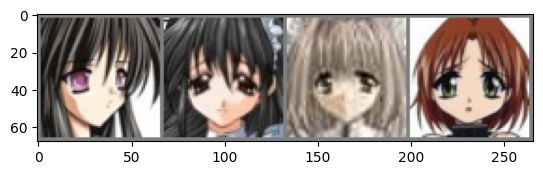

In [4]:
import os
dataset_path = os.path.join("dataset", "images")
dataset = load_dataset("imagefolder", data_dir=dataset_path, split="train")
image_size = 64
batch_size = 4
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True,
)

print("Previewing batch:")
batch = next(iter(train_dataloader))
grid = torchvision.utils.make_grid(batch["images"], nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5);

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

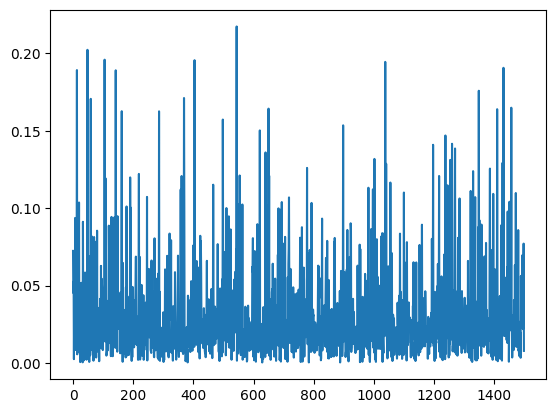

In [18]:
# Training loop

num_epochs = 6
lr = 1e-5
grad_accumulation_steps = 2

optimizer = torch.optim.AdamW(image_pipe.unet.parameters(), lr=lr)

losses = []

for epoch in range(num_epochs):
    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        clean_images = batch["images"].to(device)
        # Sampling noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        timesteps= torch.randint(
            0,
            image_pipe.scheduler.num_train_timesteps,
            (bs, ),
            device=clean_images.device,
        ).long()

        # Adding noise to the clean images according to the noise magnitude at each timesteps
        noisy_images = image_pipe.scheduler.add_noise(clean_images, noise, timesteps)

        # Getting the model prediction for the noise
        noise_pred = image_pipe.unet(noisy_images, timesteps, return_dict=False)[0]

        # Calculating loss
        loss = f.mse_loss(
            noise_pred, noise
        )

        # Storing for plotting
        losses.append(loss.item())

        # Updating the model parameters with the optimizer based on this loss
        loss.backward(loss)

        # Gradient accumulation:
        if (step + 1) % grad_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

    print(f"Epoch {epoch} average loss: {sum(losses[-len(train_dataloader):])/len(train_dataloader)}")

# Ploting the loss curve:
plt.plot(losses)
     

The loss graph is very noisy, I have tried tweeking learning rate and grad_accumulation_steps in order to reduce the noise of the loss. The other causes for the noise can be the incompatibility of the datasets. Because of which the model is having a hard time learning the pattern of the images.

0it [00:00, ?it/s]

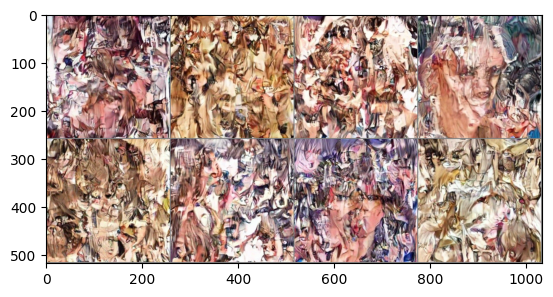

In [19]:
# Generate and plot some images:
x = torch.randn(8, 3, 256, 256).to(device)  # Batch of 8
for i, t in tqdm(enumerate(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]
    x = scheduler.step(noise_pred, t, x).prev_sample
grid = torchvision.utils.make_grid(x, nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5);

The images created from fine-tuned pipeline look nothing like a proper face or anime face though they still look quite artistic in my opinion. The cause of these photos can be due to less training. Or also the noisy training. There is also a factor that the pipeline is trained on images of 256*256 pixels but the size of anime faces is of 64 pixels. Due to 6 gb of VRAM in the graphics card. The model wasn't able to be trained on 256 pixels.

  0%|          | 0/1000 [00:00<?, ?it/s]

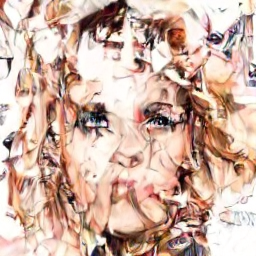

In [22]:
pipeline_output = image_pipe()
pipeline_output.images[0]

In [20]:
image_pipe.save_pretrained("my-finetuned-model")

In [21]:
# Code to upload a pipeline saved locally to the hub
from huggingface_hub import HfApi, ModelCard, create_repo, get_full_repo_name

# Set up repo and upload files
model_name = "ddpm-celebahq-finetuned-anime-6epochs"  
local_folder_name = "my-finetuned-model"  
description = "This is a celebahq sd model fine-tuned with anime faces dataset." 
hub_model_id = get_full_repo_name(model_name)
create_repo(hub_model_id)
api = HfApi()
api.upload_folder(
    folder_path=f"{local_folder_name}/scheduler", path_in_repo="", repo_id=hub_model_id
)
api.upload_folder(
    folder_path=f"{local_folder_name}/unet", path_in_repo="", repo_id=hub_model_id
)
api.upload_file(
    path_or_fileobj=f"{local_folder_name}/model_index.json",
    path_in_repo="model_index.json",
    repo_id=hub_model_id,
)

# Add a model card (optional but nice!)
content = f"""
---
license: mit
tags:
- pytorch
- diffusers
- unconditional-image-generation
- diffusion-models-class
---

# Example Fine-Tuned Model for Unit 2 of the [Diffusion Models Class 🧨](https://github.com/huggingface/diffusion-models-class)

{description}

## Usage

```python
from diffusers import DDPMPipeline

pipeline = DDPMPipeline.from_pretrained('{hub_model_id}')
image = pipeline().images[0]
image
```
"""

card = ModelCard(content)
card.push_to_hub(hub_model_id)

diffusion_pytorch_model.bin:   0%|          | 0.00/455M [00:00<?, ?B/s]

'https://huggingface.co/Hawk91/ddpm-celebahq-finetuned-anime-6epochs/blob/main/README.md'